In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
import gpt as g

from qcd_ml.nn.ptc import v_PTC
from qcd_ml.nn.lptc import v_LPTC_NG
from qcd_ml.qcd.dirac import dirac_wilson_clover
from qcd_ml.base.paths import PathBuffer

from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice

from qcd_ml.util.solver import GMRES_restarted
from qcd_ml.util.qcd.multigrid import ZPP_Multigrid

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: pc1011901129
--------------------------------------------------------------------------


SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

/home/knd35666/.local/lib/python3.12/site-packages/torch/_inductor/lowering.py:1612: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


In [2]:
def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()


def l2norm(v):
    return (v * v.conj()).real.sum()

In [3]:
U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)


w = dirac_wilson_clover(U, -0.58, 1.0)

U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.58,
    "csw_r": 1.0,
    "csw_t": 1.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))

GPT :       5.632342 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :       5.640096 s : Switching view to [1,1,1,1]/Read
GPT :       5.950220 s : Read 0.00109863 GB at 0.00354242 GB/s (0.0041972 GB/s for distribution, 0.0227097 GB/s for reading + checksum, 0.18995 GB/s for checksum, 1 views per node)
GPT :       6.002201 s : Read 0.00109863 GB at 0.0213536 GB/s (0.0485891 GB/s for distribution, 0.0381003 GB/s for reading + checksum, 0.120389 GB/s for checksum, 1 views per node)
GPT :       6.045201 s : Read 0.00109863 GB at 0.0258473 GB/s (0.0703576 GB/s for distribution, 0.0408623 GB/s for reading + checksum, 0.141658 GB/s for checksum, 1 views per node)
GPT :       6.090198 s : Read 0.00109863 GB at 0.0246759 GB/s (0.0605686 GB/s for distribution, 0.0416452 GB/s for reading + checksum, 0.119741 GB/s for checksum, 1 views per node)
GPT :       6.090666 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.463188 s


In [4]:
mg = ZPP_Multigrid.load("mg_setup.pt")

psi_coarse = mg.v_project(vec)

paths_coarse = [[]] + [[(mu, 1)] for mu in range(4)] + [[(3, -1)]]


/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml/src/qcd_ml/util/qcd/multigrid.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  args = torch.load(filenam

In [5]:
class Smoother_PTC(torch.nn.Module):
    def __init__(self, U, r_relaxation):
        super().__init__()
        self.U = U
        self.paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
        layers = [v_PTC(2, 2, self.paths, self.U) for _ in range(2 * (r_relaxation-1))]
        self.layers = torch.nn.ModuleList(layers 
                                  + [
                                        v_PTC(2, 2, self.paths, self.U)
                                        , v_PTC(2, 1, self.paths, self.U)]
                                 )

    def forward(self, v):
        for l in self.layers:
            v = l.forward(v)
        return v

class MultigridModel(torch.nn.Module):
    def __init__(self, U, r_relaxation, mg_setup: ZPP_Multigrid, paths_coarse):
        super().__init__()
        self.smoother = Smoother_PTC(U, r_relaxation)
        self.mg = mg_setup
        self.coarse_model = v_LPTC_NG(1, 1, paths_coarse, mg_setup.L_coarse, mg_setup.n_basis)

    def forward(self, v):
        v1 = v
        v2 = torch.clone(v)
        v2_c = self.mg.v_project(v2[0])
        v2_c = self.coarse_model.forward(torch.stack([v2_c]))[0]
        v2 = self.mg.v_prolong(v2_c)
        return self.smoother.forward(torch.stack([v1[0], v2]))

In [12]:
mg_model = MultigridModel(U, 2, mg, paths_coarse)

In [16]:
mg_model.smoother.load_state_dict(torch.load("smoother_start_id.pt", weights_only=True))
mg_model.coarse_model.load_state_dict(torch.load("coarse.pt", weights_only=True))

for wi in mg_model.coarse_model.parameters():
    wi.requires_grad = False

In [17]:
x, ret = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=500 // 20, maxiter_inner=30)
ret

{'converged': True, 'k': 605, 'res': tensor(9.9784e-05, dtype=torch.float64)}

  [  200|100.00%] <8.411e-07|   79>


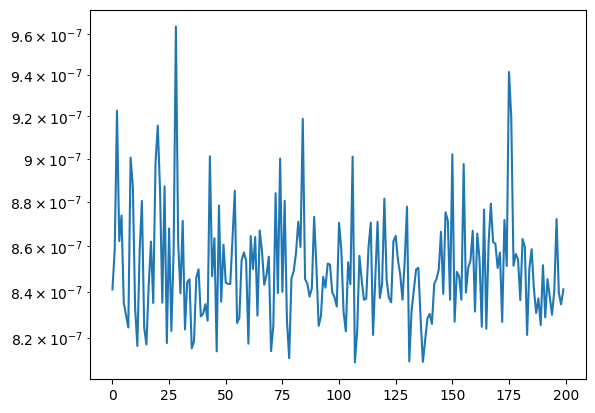

In [19]:
optimizer = torch.optim.Adam(mg_model.parameters(), lr=1e-3)
zero = torch.zeros_like(vec)

n_training = 200
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    v1 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))
    v2 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

    Dinvv2, ret = GMRES_restarted(w, v2, v2, eps=1e-3, max_restart=250 // 30, maxiter_inner=30)

    

    inp_before_norm = [w(v1), v2]
    norms = [l2norm(vi) for vi in inp_before_norm]
    
    inp = torch.stack([
        vi / ni for vi, ni in zip(inp_before_norm, norms)
    ])
    # FIXME
    outp = torch.stack([
        v1 / norms[0], Dinvv2 / norms[1]
    ])
    

    #scale = l2norm(inp[0])
    #inp = inp / scale
    #outp = outp / scale
    
    score = complex_mse_loss(mg_model.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=10, maxiter_inner=30, prec=lambda v: mg_model.forward(torch.stack([v]))[0])
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")

In [20]:
for wi in mg_model.coarse_model.parameters():
    wi.requires_grad = True

In [22]:
torch.save(mg_model.state_dict(), "mg_model.01.pt")


  [  100|100.00%] <8.345e-07|   76>


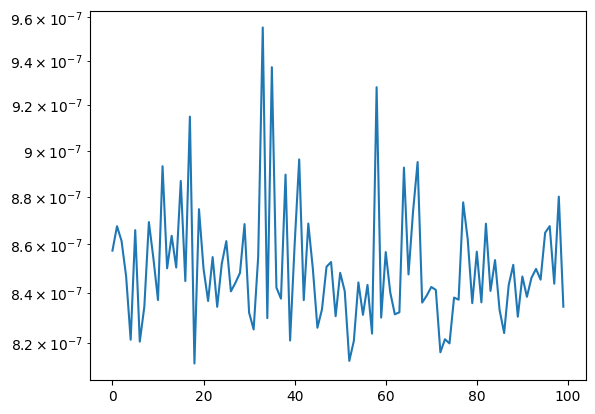

In [23]:
optimizer = torch.optim.Adam(mg_model.parameters(), lr=1e-3)
zero = torch.zeros_like(vec)

n_training = 100
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    v1 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))
    v2 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

    Dinvv2, ret = GMRES_restarted(w, v2, v2, eps=1e-3, max_restart=250 // 30, maxiter_inner=30)

    

    inp_before_norm = [w(v1), v2]
    norms = [l2norm(vi) for vi in inp_before_norm]
    
    inp = torch.stack([
        vi / ni for vi, ni in zip(inp_before_norm, norms)
    ])
    # FIXME
    outp = torch.stack([
        v1 / norms[0], Dinvv2 / norms[1]
    ])
    

    #scale = l2norm(inp[0])
    #inp = inp / scale
    #outp = outp / scale
    
    score = complex_mse_loss(mg_model.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_restarted(w, vec, vec, eps=1e-4, max_restart=10, maxiter_inner=30, prec=lambda v: mg_model.forward(torch.stack([v]))[0])
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")